# Sequence Analysis for Retail Dataset

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import ast
from collections import Counter
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules

# Load the dataset
# Assuming the data is in a CSV file, adjust the filename as needed
df = pd.read_csv('../data/sample-2/processed/customer_sequences.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
display(df.head())

# Check data types
print("\nData types:")
print(df.dtypes)

Dataset shape: (1000, 6)

First few rows:


,CustomerID,ProductID,ProductCategory,StoreID,Timestamp,TotalPrice
0,Cust_0000,"['P125', 'P112', 'P140', 'P105', 'P143', 'P112...","['Electronics', 'Home Goods', 'Grocery', 'Elec...","[4, 4, 3, 1, 6, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, ...","[Timestamp('2022-01-01 09:10:23'), Timestamp('...","[373.44, 127.13, 17.22, 114.47, 284.02, 254.26..."
1,Cust_0001,"['P138', 'P138', 'P103', 'P114', 'P149', 'P109...","['Home Goods', 'Home Goods', 'Electronics', 'A...","[1, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, ...","[Timestamp('2022-01-03 15:31:41'), Timestamp('...","[68.91, 68.91, 207.72, 168.5, 399.06, 40.91, 1..."
2,Cust_0002,"['P123', 'P143', 'P121', 'P103', 'P118', 'P149...","['Books', 'Books', 'Grocery', 'Electronics', '...","[7, 1, 1, 1, 1, 1, 1, 3, 3, 7, 7, 7, 2, 7, 7, ...","[Timestamp('2022-01-08 16:22:50'), Timestamp('...","[5.56, 142.01, 211.0, 207.72, 355.04, 399.06, ..."
3,Cust_0003,"['P127', 'P119', 'P148', 'P141', 'P145', 'P114...","['Books', 'Books', 'Books', 'Electronics', 'Gr...","[8, 3, 3, 3, 1, 5, 5, 5, 5, 6, 2, 3, 3, 3, 3, ...","[Timestamp('2022-01-10 13:41:55'), Timestamp('...","[212.94, 147.33, 169.0, 131.52, 270.34, 252.75..."
4,Cust_0004,"['P131', 'P106', 'P125', 'P132', 'P145', 'P141...","['Grocery', 'Books', 'Electronics', 'Electroni...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 7, 7, 7, 7, 6, ...","[Timestamp('2022-01-17 09:17:39'), Timestamp('...","[169.99, 272.97, 231.77, 36.18, 290.58, 87.68,..."



Data types:
CustomerID         object
ProductID          object
ProductCategory    object
StoreID            object
Timestamp          object
TotalPrice         object
dtype: object


## Data Preprocessing

In [21]:
# Convert string representations of lists to actual lists
def convert_str_to_list(s):
    try:
        if isinstance(s, str):
            # Check if it contains Timestamp objects in string format
            if "Timestamp(" in s:
                # Use regex to extract timestamp strings
                timestamp_pattern = r"Timestamp\('([^']+)'\)"
                timestamp_strings = re.findall(timestamp_pattern, s)
                if timestamp_strings:
                    return [pd.Timestamp(ts) for ts in timestamp_strings]
            # For other types of lists, use ast.literal_eval
            return ast.literal_eval(s)
        return s
    except Exception as e:
        print(f"Error converting {s}: {e}")
        return s

# Add regex import at the top if not already imported
import re

for col in ['ProductID', 'ProductCategory', 'StoreID', 'Timestamp', 'TotalPrice']:
    df[col] = df[col].apply(convert_str_to_list)

# Extract timestamp information with better error handling
def extract_first_timestamp(timestamps):
    try:
        if isinstance(timestamps, list) and len(timestamps) > 0:
            first_ts = timestamps[0]
            # Check if it's already a pandas Timestamp object
            if isinstance(first_ts, pd.Timestamp):
                return first_ts
            else:
                return pd.to_datetime(first_ts)
        elif isinstance(timestamps, str):
            # Handle case where it's still a string
            timestamp_pattern = r"Timestamp\('([^']+)'\)"
            timestamp_strings = re.findall(timestamp_pattern, timestamps)
            if timestamp_strings:
                return pd.Timestamp(timestamp_strings[0])
        return None
    except Exception as e:
        print(f"Error extracting timestamp from {timestamps}: {e}")
        return None

df['FirstPurchaseTime'] = df['Timestamp'].apply(extract_first_timestamp)

# Check for any None values and data types
print(f"Number of None values in FirstPurchaseTime: {df['FirstPurchaseTime'].isnull().sum()}")
print(f"Data type of FirstPurchaseTime: {df['FirstPurchaseTime'].dtype}")

# Extract time-based features
df['PurchaseYear'] = df['FirstPurchaseTime'].dt.year
df['PurchaseMonth'] = df['FirstPurchaseTime'].dt.month
df['PurchaseDay'] = df['FirstPurchaseTime'].dt.day
df['PurchaseHour'] = df['FirstPurchaseTime'].dt.hour
df['PurchaseWeekday'] = df['FirstPurchaseTime'].dt.dayofweek

print(f"After conversion - Number of None values: {df['FirstPurchaseTime'].isnull().sum()}")

# Display sample of the processed data
print("\nSample of processed timestamp data:")
display(df[['CustomerID', 'Timestamp', 'FirstPurchaseTime', 'PurchaseYear', 'PurchaseMonth']].head())

Number of None values in FirstPurchaseTime: 0
Data type of FirstPurchaseTime: datetime64[ns]
After conversion - Number of None values: 0

Sample of processed timestamp data:


,CustomerID,Timestamp,FirstPurchaseTime,PurchaseYear,PurchaseMonth
0,Cust_0000,"[2022-01-01 09:10:23, 2022-01-01 09:10:23, 202...",2022-01-01 09:10:23,2022,1
1,Cust_0001,"[2022-01-03 15:31:41, 2022-01-04 17:28:22, 202...",2022-01-03 15:31:41,2022,1
2,Cust_0002,"[2022-01-08 16:22:50, 2022-01-29 14:42:42, 202...",2022-01-08 16:22:50,2022,1
3,Cust_0003,"[2022-01-10 13:41:55, 2022-01-21 15:26:14, 202...",2022-01-10 13:41:55,2022,1
4,Cust_0004,"[2022-01-17 09:17:39, 2022-01-29 19:35:01, 202...",2022-01-17 09:17:39,2022,1


## Sequence Analysis

### Customer Purchase Sequence Analysis

Purchase sequence for Cust_0001:


,Timestamp,Product,Category,Store,TimeDelta
0,2022-01-03 15:31:41,P138,Home Goods,1,NaT
1,2022-01-04 17:28:22,P103,Electronics,4,1 days 01:56:41
2,2022-01-04 17:28:22,P138,Home Goods,4,0 days 00:00:00
3,2022-01-09 17:47:33,P100,Grocery,2,5 days 00:19:11
4,2022-01-09 17:47:33,P108,Grocery,2,0 days 00:00:00
5,2022-01-09 17:47:33,P109,Books,2,0 days 00:00:00
6,2022-01-09 17:47:33,P114,Apparel,2,0 days 00:00:00
7,2022-01-09 17:47:33,P149,Apparel,2,0 days 00:00:00
8,2022-01-11 14:36:27,P120,Electronics,1,1 days 20:48:54
9,2022-01-11 14:36:27,P124,Electronics,1,0 days 00:00:00


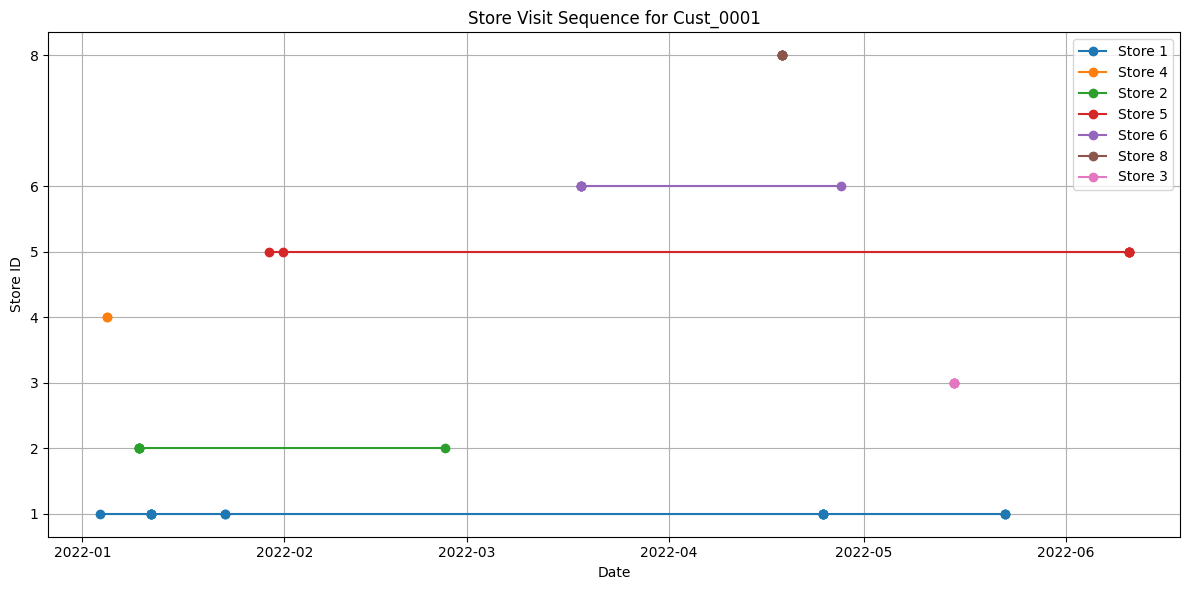

In [22]:
# Function to analyze purchase sequences by customer
def analyze_customer_sequences(customer_id):
    customer_data = df[df['CustomerID'] == customer_id].iloc[0]
    timestamps = [pd.to_datetime(ts) for ts in customer_data['Timestamp']]
    products = customer_data['ProductID']
    categories = customer_data['ProductCategory']
    stores = customer_data['StoreID']
    
    # Sort everything by timestamp
    sorted_data = sorted(zip(timestamps, products, categories, stores))
    
    # Create a sequence dataframe for this customer
    seq_df = pd.DataFrame(sorted_data, columns=['Timestamp', 'Product', 'Category', 'Store'])
    
    # Calculate time differences between purchases
    seq_df['TimeDelta'] = seq_df['Timestamp'].diff()
    
    return seq_df

# Analyze a specific customer
customer_id = 'Cust_0001'
customer_seq = analyze_customer_sequences(customer_id)
print(f"Purchase sequence for {customer_id}:")
display(customer_seq)

# Visualize the customer journey
plt.figure(figsize=(12, 6))
for store in customer_seq['Store'].unique():
    store_visits = customer_seq[customer_seq['Store'] == store]
    plt.plot(store_visits['Timestamp'], [store] * len(store_visits), 'o-', label=f'Store {store}')

plt.yticks(customer_seq['Store'].unique())
plt.xlabel('Date')
plt.ylabel('Store ID')
plt.title(f'Store Visit Sequence for {customer_id}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Store Transition Analysis

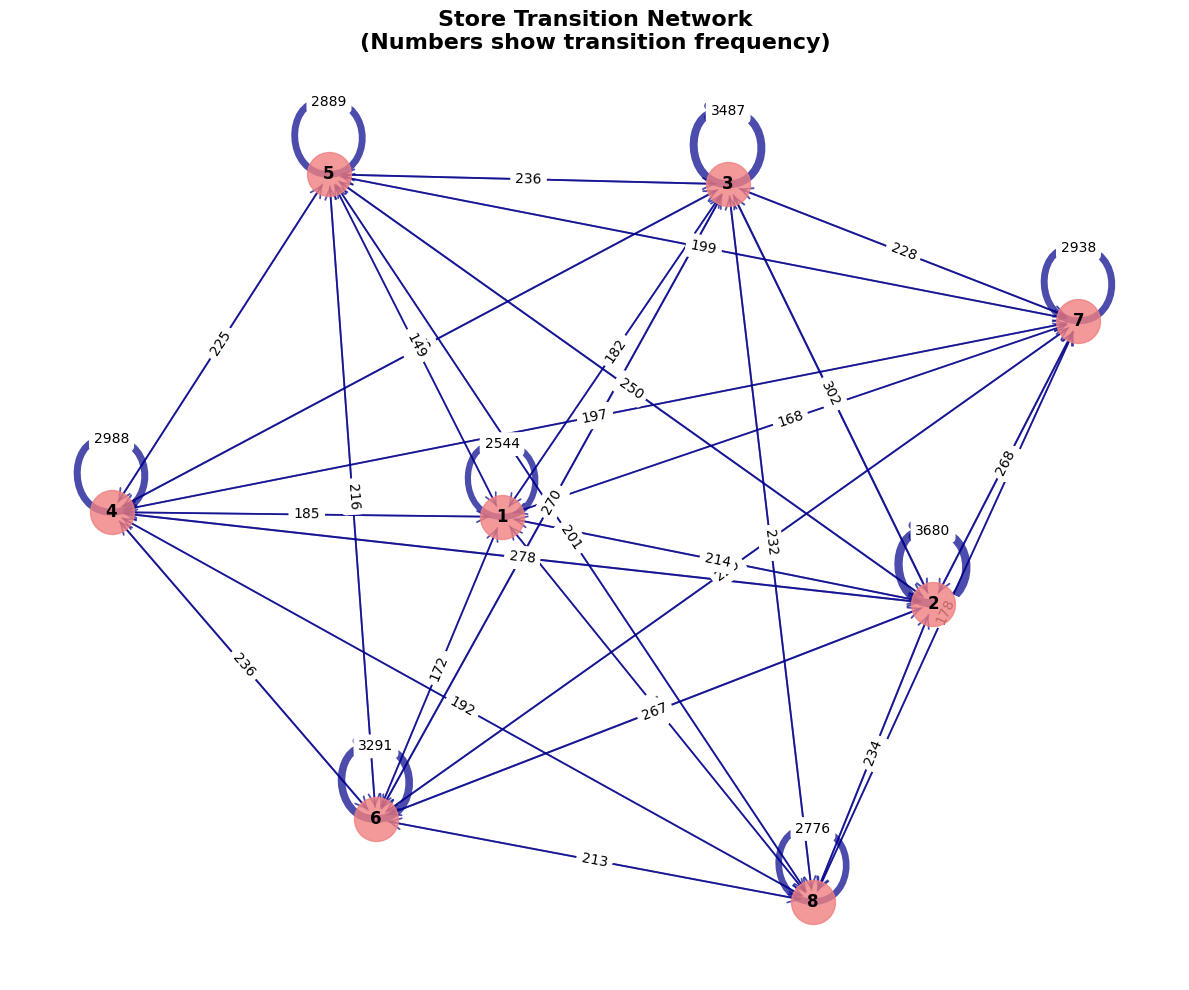


Store Transition Statistics:
Total number of transitions: 36934
Number of unique store pairs: 64

Top 10 most frequent transitions:
Store 2 → Store 2: 3680 times
Store 3 → Store 3: 3487 times
Store 6 → Store 6: 3291 times
Store 4 → Store 4: 2988 times
Store 7 → Store 7: 2938 times
Store 5 → Store 5: 2889 times
Store 8 → Store 8: 2776 times
Store 1 → Store 1: 2544 times
Store 3 → Store 2: 304 times
Store 2 → Store 3: 302 times


In [23]:
# Create a transition matrix and visualize as a network
transitions = analyze_store_transitions()

# Create a directed graph
G = nx.DiGraph()

# Add edges with weights
for (source, target), weight in transitions.items():
    G.add_edge(source, target, weight=weight)

# Plot the network with better visibility
plt.figure(figsize=(12, 10))
plt.style.use('default')  # Use default style to avoid black background

pos = nx.spring_layout(G, k=2, iterations=50)

# Scale edge widths based on weight
if len(G.edges()) > 0:
    max_weight = max([G[u][v]['weight'] for u,v in G.edges()])
    edge_width = [G[u][v]['weight']/max_weight * 5 + 1 for u,v in G.edges()]
else:
    edge_width = []

# Draw the network with better colors
nx.draw_networkx_nodes(
    G, pos,
    node_color='lightcoral',
    node_size=1000,
    alpha=0.8
)

nx.draw_networkx_labels(
    G, pos,
    font_size=12,
    font_color='black',
    font_weight='bold'
)

nx.draw_networkx_edges(
    G, pos,
    width=edge_width,
    edge_color='darkblue',
    arrows=True,
    arrowsize=20,
    arrowstyle='->',
    alpha=0.7
)

# Add edge labels with weights
edge_labels = {(u, v): f"{G[u][v]['weight']}" for u, v in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

plt.title('Store Transition Network\n(Numbers show transition frequency)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# Set white background explicitly
plt.gca().set_facecolor('white')
plt.gcf().patch.set_facecolor('white')

plt.show()

# Print transition statistics
print("\nStore Transition Statistics:")
print(f"Total number of transitions: {sum(transitions.values())}")
print(f"Number of unique store pairs: {len(transitions)}")
print("\nTop 10 most frequent transitions:")
sorted_transitions = sorted(transitions.items(), key=lambda x: x[1], reverse=True)
for (from_store, to_store), count in sorted_transitions[:10]:
    print(f"Store {from_store} → Store {to_store}: {count} times")

### Product Category Sequence Analysis

In [24]:
# Analyze product category transitions
def analyze_category_transitions():
    all_transitions = []
    
    for _, row in df.iterrows():
        categories = row['ProductCategory']
        timestamps = row['Timestamp']
        
        # Sort by timestamp
        sorted_data = sorted(zip(timestamps, categories))
        sorted_categories = [cat for _, cat in sorted_data]
        
        # Get unique categories to avoid counting transitions within the same purchase
        unique_categories = []
        for cat in sorted_categories:
            if not unique_categories or cat != unique_categories[-1]:
                unique_categories.append(cat)
        
        # Record transitions
        for i in range(len(unique_categories) - 1):
            all_transitions.append((unique_categories[i], unique_categories[i+1]))
    
    return Counter(all_transitions)

category_transitions = analyze_category_transitions()
print("Top category transitions:")
for (cat1, cat2), count in category_transitions.most_common(10):
    print(f"{cat1} → {cat2}: {count}")

Top category transitions:
Books → Electronics: 3944
Electronics → Grocery: 3666
Apparel → Books: 1817
Grocery → Home Goods: 1474
Grocery → Books: 1409
Electronics → Books: 1390
Grocery → Electronics: 1272
Apparel → Electronics: 1174
Electronics → Home Goods: 1094
Grocery → Apparel: 1084


### Time-based Purchase Patterns

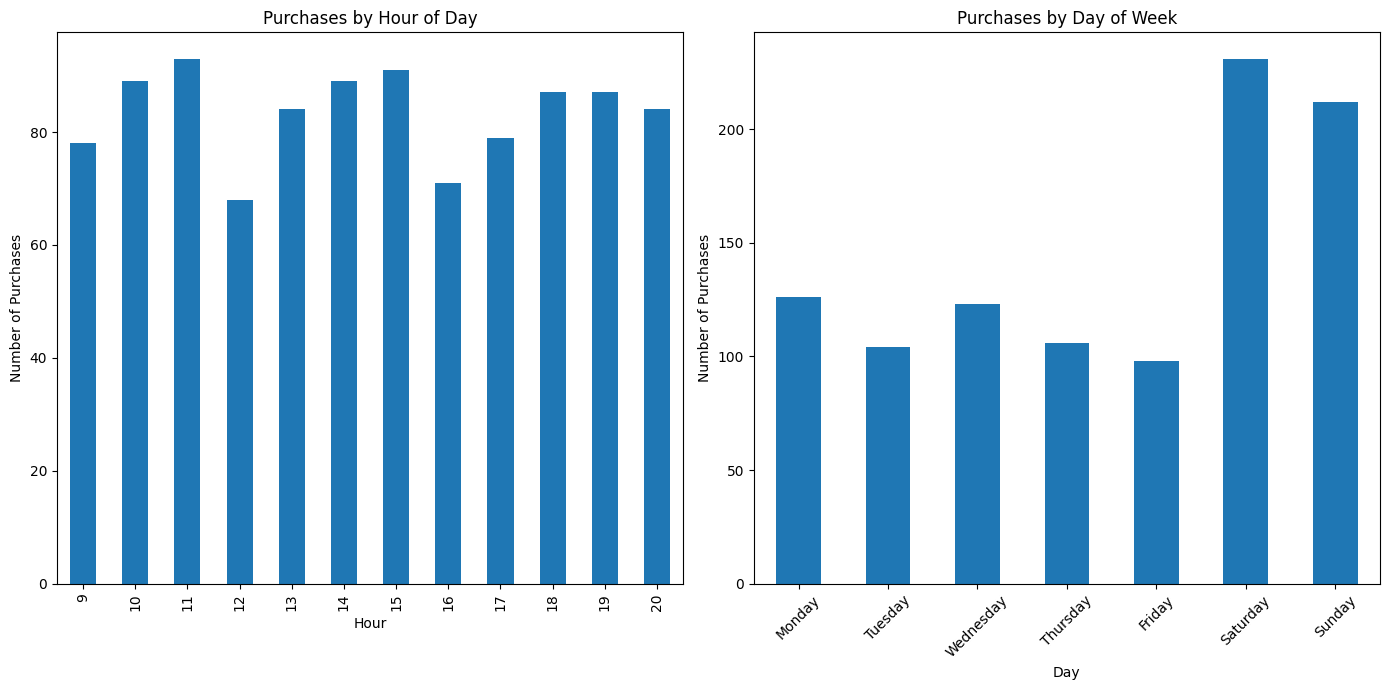

In [25]:
# Analyze purchase patterns over time
plt.figure(figsize=(14, 7))

# Plot by hour of day
plt.subplot(1, 2, 1)
df['PurchaseHour'].value_counts().sort_index().plot(kind='bar')
plt.title('Purchases by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Purchases')

# Plot by day of week
plt.subplot(1, 2, 2)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['PurchaseWeekday'].value_counts().sort_index().plot(kind='bar')
plt.xticks(range(7), days, rotation=45)
plt.title('Purchases by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Purchases')

plt.tight_layout()
plt.show()

### Market Basket Analysis

In [26]:
# Create a transaction dataset for market basket analysis
def create_transactions_data():
    transactions = []
    
    for _, row in df.iterrows():
        products = row['ProductID']
        transactions.append(products)
    
    return transactions

# Perform market basket analysis using Apriori algorithm
transactions = create_transactions_data()

# Ensure each transaction contains only unique product IDs
transactions_unique = [list(set(t)) for t in transactions]

# Convert to one-hot encoded format
transaction_df = pd.DataFrame(
    [pd.Series(1, index=t) for t in transactions_unique]
).fillna(0).astype(int)

# Apply apriori algorithm with higher min_support and limit max_len to avoid memory errors
frequent_itemsets = apriori(transaction_df, min_support=0.1, use_colnames=True, max_len=2)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display top association rules
print("Top product associations:")
if len(rules) > 0:
    display(rules.sort_values('lift', ascending=False).head(10))
else:
    print("No strong associations found with current threshold")

Top product associations:


c:\Users\Khor Kean Teng\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1613,(P137),(P102),0.300,0.286,0.103,0.343333,1.200466,1.0,0.017200,1.087310,0.238558,0.213251,0.080299,0.351737
1612,(P102),(P137),0.286,0.300,0.103,0.360140,1.200466,1.0,0.017200,1.093989,0.233880,0.213251,0.085914,0.351737
486,(P112),(P102),0.491,0.286,0.166,0.338086,1.182117,1.0,0.025574,1.078689,0.302672,0.271686,0.072949,0.459253
487,(P102),(P112),0.286,0.491,0.166,0.580420,1.182117,1.0,0.025574,1.213117,0.215771,0.271686,0.175677,0.459253
1375,(P137),(P140),0.300,0.484,0.171,0.570000,1.177686,1.0,0.025800,1.200000,0.215539,0.278956,0.166667,0.461653
1374,(P140),(P137),0.484,0.300,0.171,0.353306,1.177686,1.0,0.025800,1.082428,0.292398,0.278956,0.076151,0.461653
1033,(P109),(P113),0.442,0.200,0.103,0.233032,1.165158,1.0,0.014600,1.043068,0.254028,0.191095,0.041290,0.374016
1032,(P113),(P109),0.200,0.442,0.103,0.515000,1.165158,1.0,0.014600,1.150515,0.177184,0.191095,0.130824,0.374016
502,(P112),(P131),0.491,0.228,0.130,0.264766,1.161253,1.0,0.018052,1.050006,0.272812,0.220713,0.047624,0.417471
503,(P131),(P112),0.228,0.491,0.130,0.570175,1.161253,1.0,0.018052,1.184204,0.179872,0.220713,0.155551,0.417471


## Customer Segmentation Based on Sequence Patterns

,CustomerID,TotalPurchases,UniqueProducts,UniqueCategories,UniqueStores,PurchaseSpanDays,StoreTransitions,AvgHoursBetweenPurchases
0,Cust_0000,37,25,21,7,157,14,104.982662
1,Cust_0001,48,29,21,7,157,12,80.660579
2,Cust_0002,37,26,21,6,173,12,115.370872
3,Cust_0003,50,30,21,7,157,17,77.334955
4,Cust_0004,34,23,21,8,159,11,115.771641


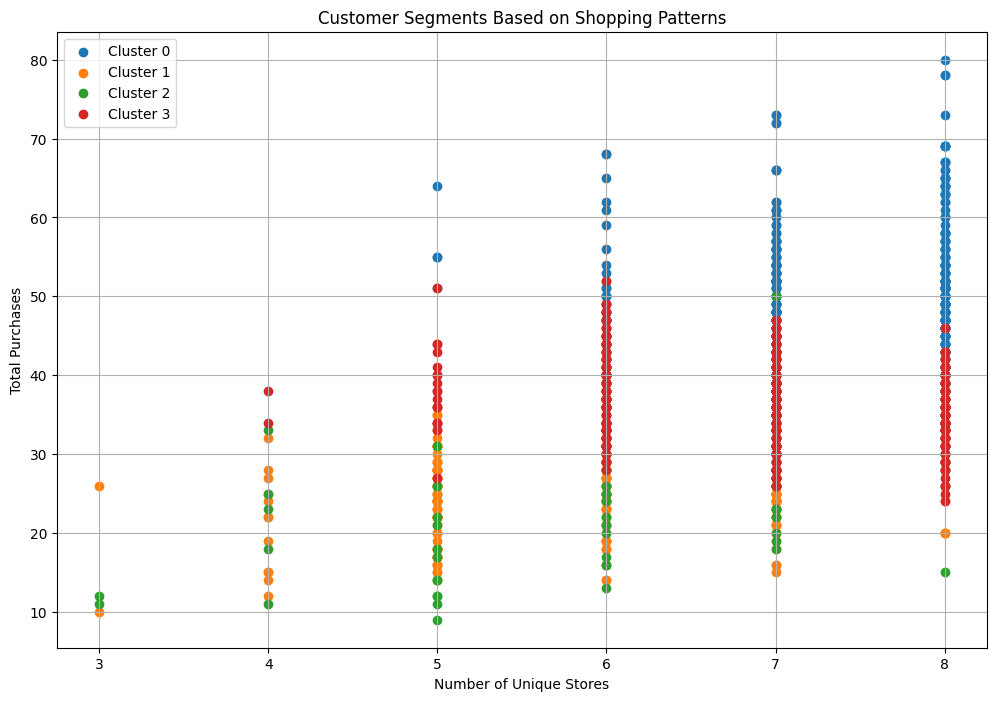

Cluster characteristics:


,TotalPurchases,UniqueProducts,UniqueCategories,UniqueStores,PurchaseSpanDays,StoreTransitions,AvgHoursBetweenPurchases
Cluster,,,,,,,
0,51.606707,29.076220,20.990854,7.429878,162.579268,15.993902,79.211322
1,24.202765,17.755760,20.986175,5.843318,147.705069,8.483871,160.636485
2,23.642857,16.428571,17.285714,5.946429,150.535714,8.696429,185.927968
3,36.167920,23.601504,21.000000,6.809524,159.390977,11.947368,111.556175


In [27]:
# Feature engineering for customer segmentation
def extract_customer_features():
    features = []
    
    for _, row in df.iterrows():
        customer = row['CustomerID']
        timestamps = [pd.to_datetime(ts) for ts in row['Timestamp']]
        products = row['ProductID']
        categories = row['ProductCategory']
        stores = row['StoreID']
        
        # Sort by timestamp
        sorted_data = sorted(zip(timestamps, products, categories, stores))
        
        # Calculate features
        total_purchases = len(timestamps)
        unique_products = len(set(products))
        unique_categories = len(set([c for cats in categories for c in cats]))
        unique_stores = len(set(stores))
        
        purchase_span = (max(timestamps) - min(timestamps)).days if len(timestamps) > 1 else 0
        
        # Store transitions
        store_transitions = 0
        if len(stores) > 1:
            for i in range(len(stores) - 1):
                if stores[i] != stores[i+1]:
                    store_transitions += 1
        
        # Average time between purchases
        avg_time_between = 0
        if len(timestamps) > 1:
            time_diffs = [(timestamps[i+1] - timestamps[i]).total_seconds()/3600 
                          for i in range(len(timestamps)-1)]
            avg_time_between = sum(time_diffs) / len(time_diffs)
        
        features.append({
            'CustomerID': customer,
            'TotalPurchases': total_purchases,
            'UniqueProducts': unique_products,
            'UniqueCategories': unique_categories,
            'UniqueStores': unique_stores,
            'PurchaseSpanDays': purchase_span,
            'StoreTransitions': store_transitions,
            'AvgHoursBetweenPurchases': avg_time_between
        })
    
    return pd.DataFrame(features)

# Create features and perform clustering
customer_features = extract_customer_features()
display(customer_features.head())

# Scale features for clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numerical columns for clustering
numerical_cols = ['TotalPurchases', 'UniqueProducts', 'UniqueCategories', 
                  'UniqueStores', 'PurchaseSpanDays', 'StoreTransitions', 
                  'AvgHoursBetweenPurchases']

# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[numerical_cols])

# Apply K-means clustering
n_clusters = 4  # You can adjust this
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    cluster_data = customer_features[customer_features['Cluster'] == cluster]
    plt.scatter(
        cluster_data['UniqueStores'], 
        cluster_data['TotalPurchases'],
        label=f'Cluster {cluster}'
    )

plt.xlabel('Number of Unique Stores')
plt.ylabel('Total Purchases')
plt.title('Customer Segments Based on Shopping Patterns')
plt.legend()
plt.grid(True)
plt.show()

# Show cluster characteristics
print("Cluster characteristics:")
display(customer_features.groupby('Cluster')[numerical_cols].mean())